In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
img_array=cv2.imread("Dataset/Face_Mask/00000_Mask.jpg")

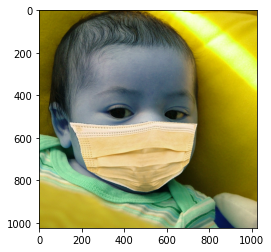

In [3]:
plt.imshow(img_array) #its BGR (cv2 always deals with BGR) we have to convert into RGB

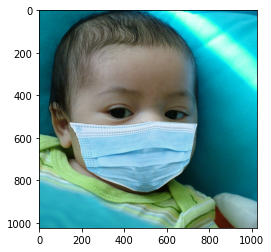

In [4]:
plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))

In [5]:
img_array.shape

(1024, 1024, 3)

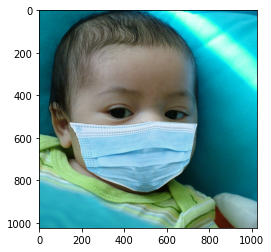

In [6]:
Datadirectory="Dataset/"  #training dataset
Classes=["Face_Mask","No_Mask"]  #List_of_classes
for category in Classes:
    path=os.path.join(Datadirectory,category)
    for img in os.listdir(path):
        img_array =cv2.imread(os.path.join(path,img))
        #backtorgb=cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break    

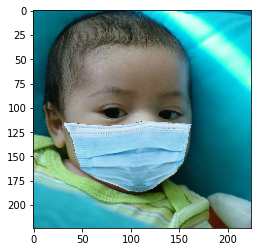

In [7]:
img_size=224   #ImageNet==>224,224
new_array=cv2.resize(img_array,(img_size,img_size))
plt.imshow(cv2.cvtColor(new_array,cv2.COLOR_BGR2RGB))
plt.show()

## reading all the images and convert into array 

In [8]:
training_Data =[]  #data
def create_training_Data():
    for category in Classes:
        path=os.path.join(Datadirectory,category)
        class_num=Classes.index(category)  #0,1 ##Label
        for img in os.listdir(path):
            try:
                img_array =cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(img_size,img_size))
                training_Data.append([new_array,class_num])
            except Exception as e:
                pass
                

In [9]:
create_training_Data()

In [10]:
print(len(training_Data))

1904


In [11]:
import random

random.shuffle(training_Data)

In [12]:
X=[] ##data/feature
y=[]  ## label

for features,label in training_Data:
    X.append(features)
    y.append(label)
    
    
X =np.array(X).reshape(-1,img_size,img_size,3)    

In [13]:
X.shape

(1904, 224, 224, 3)

In [14]:
## Normalize the data
X=X/255.0;   #we are normalizing it

In [15]:
y[1000]

1

In [16]:
Y=np.array(y)

In [17]:
import pickle

pickle_out=open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out=open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

## Deep learning model for training-Transfer Learning 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [19]:
model=tf.keras.applications.mobilenet.MobileNet() # Using mobilenet bcz its light weight

In [20]:
model.summary() #4.2M trained parameters

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

## Transfer Learning- Tuning, weights will start from last check point 

In [21]:
base_input=model.layers[0].input

In [22]:
base_output=model.layers[-4].output #last 4 layers are neglected

In [23]:
Flat_layer=layers.Flatten()(base_output)  #3 more layers are added
final_output=layers.Dense(1)(Flat_layer) ##0,1
final_output=layers.Activation('sigmoid')(final_output)

In [24]:
new_model=keras.Model(inputs=base_input,outputs=final_output)

In [25]:
new_model.summary() #we can see here 3.2M parameters

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

# Setting for binary classification (Face mask/ without mask)

In [26]:
new_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [34]:
new_model.fit(X,Y,epochs=1,validation_split=0.1)

54/54 [==============================] - 575s 10s/step - loss: 0.1583 - accuracy: 0.9333 - val_loss: 0.2216 - val_accuracy: 0.9529


In [35]:
#if we want to freeze a particular layer
#model.layers[0].trainable = false

In [ ]:
new_model.save('my_model.h5')

In [3]:
new_model =tf.keras.models.load_model('my_model.h5')

## checking the network for predictions

In [4]:
frame=cv2.imread('download.jpg')

In [5]:
frame.shape

(172, 292, 3)

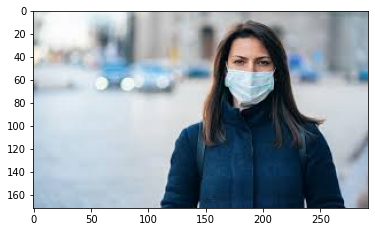

In [6]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [7]:
final_image=cv2.resize(frame,(224,224))
final_image =np.expand_dims(final_image,axis=0)  #need 4th dimensions
final_image=final_image/255.0

In [8]:
Predictions=new_model.predict(final_image)

In [9]:
Predictions

array([[3.64875e-10]], dtype=float32)

In [10]:
faceCascade= cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [11]:
gray =cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [12]:
gray.shape

(172, 292)

In [13]:
faces =faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    roi_gray =gray[y:y+h,x:x+w]
    roi_color =frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x,y), (x+w,y+h), (225,0,0), 2)
    facess=faceCascade.detectMultiScale(roi_gray)
    if len(faces) ==0:
        print("Face not detected")
    else:
        for (ex,ey,ew,eh) in facess:
            face_roi =roi_color[ey: ey+eh, ex:ex +ew]

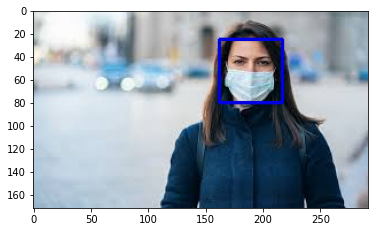

In [14]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

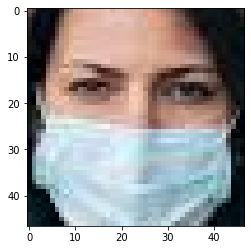

In [15]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [16]:
final_image=cv2.resize(face_roi,(224,224))
final_image =np.expand_dims(final_image,axis=0)  #need 4th dimensions
final_image=final_image/255.0

In [17]:
Predictions=new_model.predict(final_image)

In [18]:
Predictions

array([[2.4573742e-08]], dtype=float32)

## Real time video Demo

## Face Mask Detection

In [ ]:
import cv2 

path="haarcascade_frontalface_default.xml"
font_scale =1.5
font=cv2.FONT_HERSHEY_PLAIN

#SET the rectangle background to white
rectangle_bgr =(225,225,225)

#make a black image
img=np.zeros((500,500))

#set same text
text="Some text in a box!"

#get the width and height of the text box
(text_width, text_height)=cv2.getTextSize(text,font,fontScale=font_scale,thickness=1)[0]

#set the text start position
text_offset_x= 10
text_offset_y=img.shape[0] - 25

#make the cords of the box with a small padding of two pixels
box_coords=((text_offset_x,text_offset_y), (text_offset_x+ text_width + 2, text_offset_y - text_height -2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x,text_offset_y), font, fontScale=font_scale, color=(0,0,0), thickness=1)

cap=cv2.VideoCapture(1)

#check if the webcam is opened correctly

if not cap.isOpened():
    cap=cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")
    
while True:
    ret,frame=cap.read()
    #eye_Cascade =cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_eye.xml')
    faceCascade=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #print(faceCascade.empty())
    faces =faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray =gray[y:y+h, x:x+w]
        roi_color =frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (225,0,0), 2)
        facess=faceCascade.detectMultiScale(roi_gray)
        if len(facess)==0:
            print("Face not detected")
        else:
            for (ex,ey,ew,eh) in facess:
                face_roi = roi_color[ey:ey+eh, ex:ex+ew]   #croping the face
     
    
    final_image =cv2.resize(face_roi, (224,224))
    final_image =np.expand_dims(final_image, axis=0) #need fourth dimension
    final_image=final_image/255.0
    
    font =cv2.FONT_HERSHEY_SIMPLEX
    
    Predictions =new_model.predict(final_image)
    
    font_scale =1.5
    font =cv2.FONT_HERSHEY_PLAIN
    
    if (Predictions>0.1):
        status ="No Mask"
        
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black background rectangle
        cv2.rectangle(frame, (x1,x1), (x1+w1, y1+h1), (0,0,0), -1)
        #add text
        cv2.putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        cv2.putText(frame, status,(100,150), font, 3, (0,0,225),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    else:
        status ="Face Mask"
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black background rectangle
        cv2.rectangle(frame, (x1,x1), (x1+w1, y1+h1), (0,0,0), -1)
        #add text
        cv2.putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        cv2.putText(frame, status,(100,150), font, 3, (0,255,0),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0))
        
    #gray =cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #print(faceCascade.empty())
    #faces = faceCascade.detectMultiScale(gray, 1.1,4)
    
    #draw a rectangle around the faces
    #for(x,y,w,h) in faces:
    #    cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), 2)
    
    
    
    #Use putText() method for
    #Inserting text on video
    
    
    cv2.imshow('Face Mask Detection Tutorial', frame)
    
    if cv2.waitKey(2) & 0xFF ==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()